In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
df = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')
print(df.head(10))

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815      170136.00       160296.36   
1     1   PAYMENT   1864.28  C1666544295       21249.00        19384.72   
2     1  TRANSFER    181.00  C1305486145         181.00            0.00   
3     1  CASH_OUT    181.00   C840083671         181.00            0.00   
4     1   PAYMENT  11668.14  C2048537720       41554.00        29885.86   
5     1   PAYMENT   7817.71    C90045638       53860.00        46042.29   
6     1   PAYMENT   7107.77   C154988899      183195.00       176087.23   
7     1   PAYMENT   7861.64  C1912850431      176087.23       168225.59   
8     1   PAYMENT   4024.36  C1265012928        2671.00            0.00   
9     1     DEBIT   5337.77   C712410124       41720.00        36382.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0            0.00        0               0  
1  M2044282225            

In [6]:
# check null values
df.isnull().values.any()

False

In [7]:
# check types
pd.unique(df['type'])

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

1. Describe the dataset and any issues with it:

In this dataset, each row denotes a transaction and each column denotes an attribute corresponding to them.
In detail, columns are:
    step: a variable related to time for each transaction.
    type: type of transaction, including "PAYMENT", "TRANSFER", "CASH_OUT", "CASH_IN" and "DEBIT".
    amount: size of transactions.
    nameOrig: holder of originating account. I noticed that these "names" always start by a character "C" or "M", 
    possibly denotes clients and merchants.
    oldbalanceOrg: balance of originating account before making the transaction.
    newbalanceOrig: balance of originating account after making the transaction.
    nameDest: holder of destination account.
    oldbalanceDest: balance of destination account before making the transaction.
    newbalanceDest: balance of destination account after making the transaction.
    isFraud: identifier showing whether the transaction is a fraud.
    isFlaggeredFraud: identifier showing whether the transaction is a potential fraud predicted by a model.

Before actually diving into the dataset, I did find an obvious issue with it, that after doing transactions like "TRANSFER" or "PAYMENT", the balance of destination account does not increase, specifically related to those merchant accounts. One potential reason of this can be the lack of data of these accounts. Although there is no NULL values in this dataset, the 0 values may cause problems because we do not know whether they are missing or indeed 0.
    

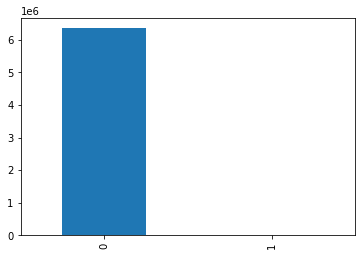

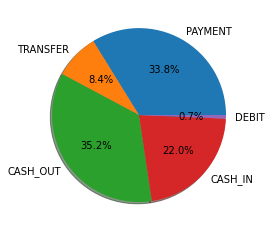

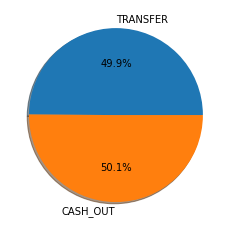

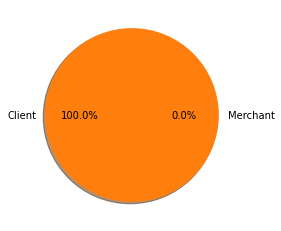

<AxesSubplot:>

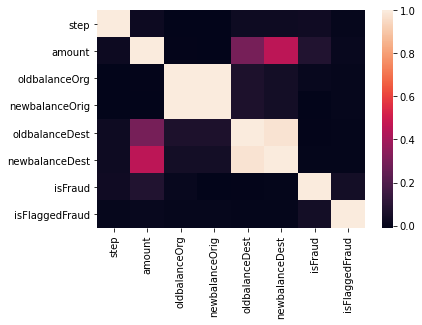

In [7]:
# generate visualizations

# bar chart denoting number of fraud vs number of non-fraud
df['isFraud'].value_counts().plot(kind='bar')


labels = ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'CASH_IN', 'DEBIT']
labels2 = pd.unique(df[df['isFraud']==1]['type'])
sizes1 = []
sizes2 = []
for l in labels:
    sizes1.append(df.loc[df['type'] == l].shape[0]/df.shape[0])
for l in labels2:
    sizes2.append(df.loc[(df['isFraud'] == 1) & (df['type'] == l)].shape[0]/df.loc[df['isFraud'] == 1].shape[0])

sizes3 = [df.loc[(df['isFraud'] == 1) & (df['nameDest'].str.contains('M'))].shape[0]/df.loc[df['isFraud'] == 1].shape[0], 
          df.loc[(df['isFraud'] == 1) & (df['nameDest'].str.contains('C'))].shape[0]/df.loc[df['isFraud'] == 1].shape[0]]
    
# pie chart denoting fractions of each type of transaction in all transactions
fig1, ax1 = plt.subplots()
# pie chart denoting percentage each type of transaction takes in Fraud transactions
fig2, ax2 = plt.subplots()
#
fig3, ax3 = plt.subplots()
ax1.pie(sizes1, explode=(0,0,0,0,0), labels=labels, autopct='%1.1f%%',
        shadow=True)
ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%',
        shadow=True)
ax3.pie(sizes3, labels=['Merchant', 'Client'], autopct='%1.1f%%',
        shadow=True)

plt.show()

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [39]:
df['client'] = df['nameDest'].str.contains('C')
df['isTRANSFER'] = df['type']=='TRANSFER'
df['isPAYMENT'] = df['type']=='PAYMENT'
df['isCASH_OUT'] = df['type']=='CASH_OUT'
df['isCASH_IN'] = df['type']=='CASH_IN'
df['isDEBIT'] = df['type']=='DEBIT'


features = ['step', 'amount', 'client', 'isTRANSFER', 'isCASH_OUT', 'isCASH_IN', 'isDEBIT', 'isPAYMENT', 'oldbalanceOrg',
            'newbalanceOrig',
            'oldbalanceDest',
            'newbalanceDest',]

# features = ['amount', 'client', 'isTRANSFER', 'isCASH_OUT', 'isCASH_IN', 'isDEBIT', 'isPAYMENT', 'oldbalanceOrg']


label = ['isFraud']

X = df[features]
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y,
                                                   test_size=0.15,
                                                   random_state=42)

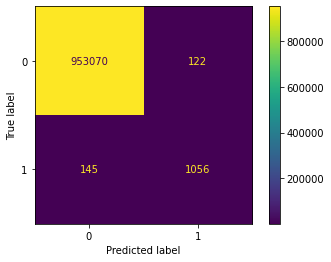

In [40]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

metrics.plot_confusion_matrix(clf, X_test, y_test)

In [41]:
from sklearn.metrics import accuracy_score

print(metrics.classification_report(y_test, y_pred))
print ("Decision Tree Accuracy", accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953192
           1       0.90      0.88      0.89      1201

    accuracy                           1.00    954393
   macro avg       0.95      0.94      0.94    954393
weighted avg       1.00      1.00      1.00    954393

Decision Tree Accuracy 0.9997202410327821


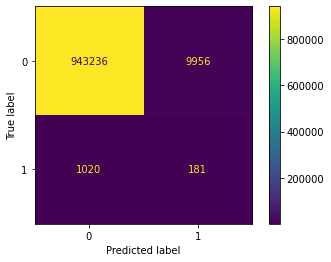

In [37]:
gnb = GaussianNB()
model = gnb.fit(X_train,y_train.values.ravel())
predictions = model.predict(X_test)

metrics.plot_confusion_matrix(model, X_test, y_test)

In [38]:
print(metrics.classification_report(y_test, y_pred))

print ("Navie bayes Accuracy", accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953192
           1       0.77      0.80      0.78      1201

    accuracy                           1.00    954393
   macro avg       0.89      0.90      0.89    954393
weighted avg       1.00      1.00      1.00    954393

Navie bayes Accuracy 0.9884994965386377
